In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from os import chdir
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, LSTM, Embedding, GRU
from tensorflow.keras.layers import Dropout

from sklearn.model_selection import train_test_split

import pickle
from IPython.display import clear_output

In [2]:
#планируется словарь алгоритмов для более быстрого создания всех датафреймов
alg_dict = {'sort': ['bubble_sort', 'quick_sort','selection_sort','merge_sort','insertion_sort'], 'find': ['binary_search']}

In [3]:
#создание датафрейма
def make_df():
    df = pd.read_csv('csv\dataset_test_5_sort.csv')
    df = df.set_index('filename')
    del df['Unnamed: 0']
    return df

In [4]:
def classification_sort(df):
    cnt = 0
    df = df[df['algorithm'] == 'sort']
    sort_class = []
    for language,algorithm,algorithm_name in zip(df['language'],df['algorithm'],df['algorithm_name']):
        algorithm_name = algorithm_name.strip()
        if algorithm_name == 'bubble_sort':
            sort_class.append([1,0,0,0,0])
        if algorithm_name == 'quick_sort':
            sort_class.append([0,1,0,0,0])
        if algorithm_name == 'selection_sort':
            sort_class.append([0,0,1,0,0])
        if algorithm_name == 'merge_sort':
            sort_class.append([0,0,0,1,0])
        if algorithm_name == 'insertion_sort':
            sort_class.append([0,0,0,0,1])
    return df, np.array(sort_class)

In [5]:
def classification_find(df):
    df = df[df['algorithm'] == 'find']
    find_class = []
    for language,algorithm,algorithm_name in zip(df['language'],df['algorithm'],df['algorithm_name']):
        algorithm_name = algorithm_name.strip()
        if algorithm_name == 'binary_search':
            find_class.append([1,0])
    return df, find_class

In [6]:
def file_read(df):
    new_lines = []
    #df = df.sort_values(by='filename')
    for index, row in df.iterrows():
        chdir(f'dataset/{row[1]}/{row[2]}')
        with open(str(index),'r', encoding = 'utf-8') as f:
            lines = f.readlines()
            lines = [line for line in lines if line.strip() != ""]
        %cd ../../..
        new_lines.append(lines)
    #%cd ../..
    return new_lines

In [7]:
#обработка переменной без табов, заменяя их на 2 пробела (Доработать)
def preporcessing_files(lines):
    new_lines = []
    code_line = ''
    for i in lines:
        for j in i:
            j = j.replace('    ', ' ')
            code_line += j
        new_lines.append(code_line)
    return new_lines

In [8]:
df = make_df()

In [9]:
#Для сортировки
df_sort, classes_sort = classification_sort(df)
files_sort = file_read(df_sort)
pre_files_sort = preporcessing_files(files_sort)
clear_output()

In [10]:
df_sort

,language,algorithm,algorithm_name
filename,,,
bubble_sort.py,py,sort,bubble_sort
bubble_sort.py,py,sort,bubble_sort
bubble_sort.py,py,sort,bubble_sort
bubble_sort.py,py,sort,bubble_sort
bubble_sort.py,py,sort,bubble_sort
...,...,...,...
insertion_sort.py,py,sort,insertion_sort
insertion_sort.py,py,sort,insertion_sort
insertion_sort.py,py,sort,insertion_sort


# Основная часть, построение архитектуры

In [11]:
maxWord = 10
max_text_len = 400
tokenizer = Tokenizer(num_words=maxWord, lower = True, split = ' ', char_level=False)
tokenizer.fit_on_texts(pre_files_sort) #Меняем данные
dist = list(tokenizer.word_counts.items())
data = tokenizer.texts_to_sequences(pre_files_sort) #Меняем данные 
data_pad = pad_sequences(data,maxlen = max_text_len)
X = data_pad
Y = classes_sort

In [12]:
# with open('files\\5_sort.pickle', 'wb') as file:
#     pickle.dump(pre_files_sort, file)

In [12]:
len(data_pad) == len(X) == len(Y) == len(pre_files_sort)

True

In [13]:
model = Sequential([
    Embedding(maxWord, 64, input_length = max_text_len),
    LSTM(32, return_sequences=True),
    LSTM(8),
    Dense(5, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 400, 64)           640       
_________________________________________________________________
lstm (LSTM)                  (None, 400, 32)           12416     
_________________________________________________________________
lstm_1 (LSTM)                (None, 8)                 1312      
_________________________________________________________________
dense (Dense)                (None, 5)                 45        
Total params: 14,413
Trainable params: 14,413
Non-trainable params: 0
_________________________________________________________________


In [14]:
model.compile(loss ='categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(0.0001))

In [55]:
train_data, val_data, train_class, val_class = train_test_split(X,Y, test_size=0.2)

In [56]:
print(np.sum(np.all(val_class == np.array([0,0,0,0,1]), axis=1)))
print(np.sum(np.all(val_class == np.array([0,0,0,1,0]), axis=1)))
print(np.sum(np.all(val_class == np.array([0,0,1,0,0]), axis=1)))
print(np.sum(np.all(val_class == np.array([0,1,0,0,0]), axis=1)))
print(np.sum(np.all(val_class == np.array([1,0,0,0,0]), axis=1)))

21
19
22
19
20


In [59]:
history = model.fit(train_data,train_class, validation_data=(val_data,val_class), batch_size = 512, epochs = 100)

Epoch 1/100
1/1 [==============================] - 0s 299ms/step - loss: 0.9776 - accuracy: 0.7946 - val_loss: 0.9908 - val_accuracy: 0.7624
Epoch 2/100
1/1 [==============================] - 0s 71ms/step - loss: 0.9756 - accuracy: 0.7946 - val_loss: 0.9889 - val_accuracy: 0.7624
Epoch 3/100
1/1 [==============================] - 0s 70ms/step - loss: 0.9738 - accuracy: 0.7946 - val_loss: 0.9869 - val_accuracy: 0.7624
Epoch 4/100
1/1 [==============================] - 0s 67ms/step - loss: 0.9719 - accuracy: 0.7970 - val_loss: 0.9850 - val_accuracy: 0.7624
Epoch 5/100
1/1 [==============================] - 0s 70ms/step - loss: 0.9700 - accuracy: 0.7970 - val_loss: 0.9831 - val_accuracy: 0.7624
Epoch 6/100
1/1 [==============================] - 0s 66ms/step - loss: 0.9682 - accuracy: 0.7970 - val_loss: 0.9812 - val_accuracy: 0.7624
Epoch 7/100
1/1 [==============================] - 0s 59ms/step - loss: 0.9664 - accuracy: 0.7970 - val_loss: 0.9792 - val_accuracy: 0.9802
Epoch 8/100
1/1 [==

1/1 [==============================] - 0s 57ms/step - loss: 0.8712 - accuracy: 0.9752 - val_loss: 0.8779 - val_accuracy: 0.9802
Epoch 60/100
1/1 [==============================] - 0s 59ms/step - loss: 0.8691 - accuracy: 0.9777 - val_loss: 0.8754 - val_accuracy: 0.9802
Epoch 61/100
1/1 [==============================] - 0s 61ms/step - loss: 0.8669 - accuracy: 0.9777 - val_loss: 0.8730 - val_accuracy: 0.9802
Epoch 62/100
1/1 [==============================] - 0s 63ms/step - loss: 0.8647 - accuracy: 0.9777 - val_loss: 0.8706 - val_accuracy: 0.9802
Epoch 63/100
1/1 [==============================] - 0s 60ms/step - loss: 0.8626 - accuracy: 0.9777 - val_loss: 0.8680 - val_accuracy: 0.9901
Epoch 64/100
1/1 [==============================] - 0s 70ms/step - loss: 0.8603 - accuracy: 0.9777 - val_loss: 0.8654 - val_accuracy: 0.9901
Epoch 65/100
1/1 [==============================] - 0s 56ms/step - loss: 0.8580 - accuracy: 0.9777 - val_loss: 0.8628 - val_accuracy: 0.9901
Epoch 66/100
1/1 [========

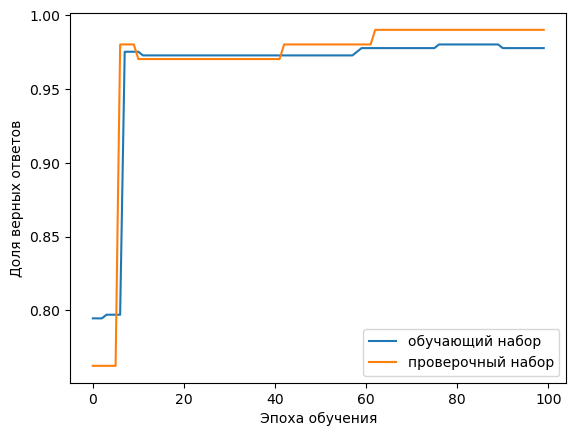

In [60]:
plt.plot(history.history['accuracy'],
         label='обучающий набор')
plt.plot(history.history['val_accuracy'],
         label='проверочный набор')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()
plt.show()

# Тест моделей

In [61]:
def test_model(text,max_text_len = max_text_len,model=model):
    test_text = text.lower()
    data_test = tokenizer.texts_to_sequences([test_text])
    data_pad_test = pad_sequences(data_test, maxlen = max_text_len)
    res = model.predict(data_pad_test)
    return res, np.argmax(res)

In [62]:
test_model("""def bubble_sort(arr):
    n = len(arr)
    for i in range(n):
        for j in range(0, n - i - 1):
            if arr[j] > arr[j + 1]:
                arr[j], arr[j + 1] = arr[j + 1], arr[j]
    return arr""")

(array([[0.4914528 , 0.10405684, 0.2090128 , 0.10777248, 0.08770508]],
       dtype=float32),
 0)

In [63]:
test_model("""def quicksort(arr):
        if len(arr) <= 1:
            return arr
        else:
            pivot = arr[0]
            less = [x for x in arr[1:] if x <= pivot]
            greater = [x for x in arr[1:] if x > pivot]
            return quicksort(less) + [pivot] + quicksort(greater)
            """)

(array([[0.38142234, 0.13802646, 0.27789634, 0.090442  , 0.11221289]],
       dtype=float32),
 0)

In [64]:
test_model("""def selection_sort(arr):        
    for i in range(len(arr)):
        minimum = i
        for j in range(i + 1, len(arr)):
            if arr[j] < arr[minimum]:
                minimum = j
        arr[minimum], arr[i] = arr[i], arr[minimum]
    return arr""")

(array([[0.35057703, 0.08988616, 0.40114072, 0.08016559, 0.07823058]],
       dtype=float32),
 2)

In [65]:
test_model("""import operator
def merge_sort(L, compare=operator.lt):
    if len(L) < 2:
        return L[:]
    else:
        middle = int(len(L) / 2)
        left = merge_sort(L[:middle], compare)
        right = merge_sort(L[middle:], compare)
        return merge(left, right, compare)
        
        def merge(left, right, compare):
    result = []
    i, j = 0, 0
    while i < len(left) and j < len(right):
        if compare(left[i], right[j]):
            result.append(left[i])
            i += 1
        else:
            result.append(right[j])
            j += 1
    while i < len(left):
        result.append(left[i])
        i += 1
    while j < len(right):
        result.append(right[j])
        j += 1
    return result""")

(array([[0.10859567, 0.1012047 , 0.10687285, 0.56894284, 0.11438391]],
       dtype=float32),
 3)

In [99]:
test_model("""
def partition(arr, low, high):
    pivot = arr[high]
    i = low - 1
    
    for j in range(low, high):
        if arr[j] <= pivot:
            i += 1
            arr[i], arr[j] = arr[j], arr[i]

    arr[i + 1], arr[high] = arr[high], arr[i + 1]
    return i + 1

def quicksort(arr, low=0, high=None):
    if high is None:
        high = len(arr) - 1

    if low < high:
        pivot_index = partition(arr, low, high)

        quicksort(arr, low, pivot_index - 1)
        quicksort(arr, pivot_index + 1, high)

    return arr

    """)

(array([[0.21668047, 0.28920454, 0.23970933, 0.04386024, 0.21054535]],
       dtype=float32),
 1)

In [101]:
# model.save('models\\test_5_sort.h5).h5')

In [ ]:
# models\\test_4_sort(3).h5
# maxWord = 30
# max_text_len = 50

In [36]:
# models\\test_4_sort(4).h5
# maxWord = 30
# max_text_len = 100

In [ ]:
# model.save('models\\test_4_sort(5).h5')
# maxWord = 15
# max_text_len = 30

In [ ]:
# model.save('models\\test_4_sort(6).h5')
# maxWord = 15
# max_text_len = 40

In [ ]:
# model.save('models\\test_4_sort(7).h5')
# maxWord = 15
# max_text_len = 40

In [ ]:
# model.save('models\\test_4_sort(8).h5')
# maxWord = 25
# max_text_len = 30

In [ ]:
# model.save('models\\test_5_sort.h5')
# maxWord = 25
# max_text_len = 400

# Вспомогательные функции

In [19]:
pwd

'C:\\Users\\Matvey\\Анализ кода\\Code-Insight\\dataset'

In [22]:
%cd Анализ кода/Code-Insight

C:\Users\Matvey\Анализ кода\Code-Insight


In [18]:
%cd ../..

C:\Users\Matvey\Анализ кода\Code-Insight\dataset


In [20]:
%cd ../

C:\Users\Matvey\Анализ кода\Code-Insight


In [ ]:
%cd ../../..